<a href="https://colab.research.google.com/github/lacykaltgr/ait-assessments/blob/main/13_GAN_MNIST_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Copyright

<PRE>
You may use and modify this code for research and development purpuses.
Using this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.

Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved
</PRE>

## Introduction to Generative Adversarial Networks (GANs) for MNIST Dataset

In this notebook, we'll explore Generative Adversarial Networks (GANs), a fascinating deep learning technique that has gained significant attention in recent years. We'll focus on using GANs for generating handwritten digits, based on the popular MNIST dataset. This notebook shows an example for the basic GAN architecture, generated images are unconditioned. 

GANs were introduced by Ian Goodfellow and his colleagues in 2014, and they have since revolutionized the field of generative modeling. GANs consist of two neural networks, a generator and a discriminator, that compete against each other in a zero-sum game. The generator tries to create realistic data samples, while the discriminator's goal is to determine whether the samples are real (from the actual dataset) or fake (generated by the generator). Through this adversarial process, the generator becomes better at creating realistic data, while the discriminator improves its ability to distinguish between real and fake samples.

In [1]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential, Model

import matplotlib.pyplot as plt
import numpy as np

Class called GAN_image that encapsulates the logic for building and training a Generative Adversarial Network (GAN) for generating images. The class contains three main methods: build_discriminator, build_generator, and the class constructor __init__.


In [13]:
class GAN_image():

  """ 
  This method initializes the GAN_image class and compiles the models. It sets the image dimensions, defines the optimizer, and calls the 
  """
  def __init__(self):
    self.img_rows = 28
    self.img_cols = 28
    self.channels = 1
    self.img_shape = (self.img_rows, self.img_cols, self.channels)
    self.latent_dim = 100 # noise dim
    optimizer = keras.optimizers.legacy.Adam(0.0002, 0.5)
    
    self.discriminator = self.build_discriminator() # building discriminator
    self.discriminator.compile(loss = 'binary_crossentropy', optimizer=optimizer, metrics=['accuracy']) # classify fake and real images
    
    self.generator = self.build_generator() # building generator
    
    z = Input(shape=(self.latent_dim,)) # input is noise
    img = self.generator(z) # generator generates image from noise
    
    # training generator only
    self.discriminator.trainable = False
    # discriminator determines if the generated image is real or fake
    validity = self.discriminator(img)
    
    # combined model, both generator and discriminator
    self.combined = Model(inputs= z, outputs=validity) # input: noise, output: discriminator output
    self.combined.compile(loss = 'binary_crossentropy', optimizer=optimizer) 

  """
  This method creates the discriminator model, which is responsible for classifying images as real (from the dataset) or fake (generated by the generator). The model is a simple feedforward neural network with the following layers:

  Flatten: Converts the 28x28x1 input image into a 1D vector.
  Dense layers: Three fully connected layers with 512, 256, and 1 neurons, respectively.
  LeakyReLU: Non-linear activation functions with a small slope for negative input values.
  Sigmoid activation: Converts the final output to a probability (0 to 1) representing whether the input image is real or fake.
  """
  def build_discriminator(self): 
    model = Sequential()
    
    model.add(Flatten(input_shape = self.img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid')) # single output for binary classification with the correct activation function
    
    print("Discriminator")
    model.summary()
    
    img = Input(shape=self.img_shape)
    
    validity = model(img)
    
    return Model(img, validity)
  
  """
  This method creates the generator model, which takes random noise as input and generates a 28x28x1 image as output. The generator is also a feedforward neural network with the following layers:

  Dense layers: Four fully connected layers with 256, 512, 1024, and np.prod(self.img_shape) neurons, respectively.
  LeakyReLU: Non-linear activation functions with a small slope for negative input values.
  BatchNormalization: Normalizes the activations of the previous layer to improve training stability.
  Tanh activation: Scales the final output values between -1 and 1.
  Reshape: Converts the 1D output vector into a 28x28x1 image.
  """
  def build_generator(self):
    model = Sequential()
    
    model.add(Dense(256, input_dim = self.latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8)) 
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(self.img_shape), activation='tanh'))
    model.add(Reshape(self.img_shape))
    
    print("Generator")
    model.summary()
    
    noise = Input(shape=(self.latent_dim,))
    img = model(noise)
    
    return Model(noise, img)
  
  

In [14]:
# training parameters
steps           = 30000
batch_size      = 256
# creating the GAN
gan = GAN_image()

Discriminator
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_17 (Dense)            (None, 512)               401920    
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 

In [15]:
# loading the dataset
from keras.datasets import mnist
(x_train, _), (_, _) = mnist.load_data()

# scaling images 
x_train = x_train / 127.5 - 1
x_train = np.expand_dims(x_train, axis = 3) # legyen channel dim is

# defining outputs for discriminator (real and fake)
valid = np.ones((batch_size, 1)) # D(x)    = 1
fake = np.zeros((batch_size, 1)) # D(G(z)) = 0


In [16]:
# dispalying generated images
from IPython import display
def plot_images(gan, step):
  r, c = 2,10
  noise = np.random.normal(0, 1, (r * c, gan.latent_dim))
  gen_imgs = gan.generator.predict(noise,verbose=0)
  
  # átskálázás: 0-1 (from -1 -- 1)
  gen_imgs = 0.5 * gen_imgs + 0.5
  
  plt.title('step ' + str(step))
  fig, ax = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      ax[i,j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      ax[i,j].axis('off')
      cnt += 1
  
  display.display(plt.gcf())
      

8/8 [==============================] - 0s 4ms/step
0 loss_D 0.029913789592683315 loss_G 3.9285337924957275


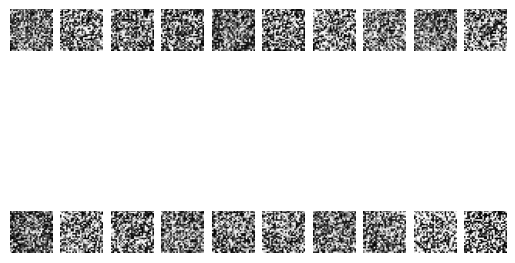

8/8 [==============================] - 0s 2ms/step
100 loss_D 0.2910958155989647 loss_G 2.7051243782043457


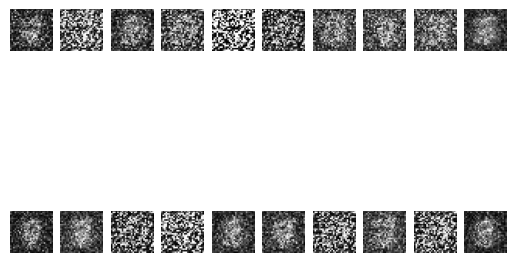

8/8 [==============================] - 0s 2ms/step
200 loss_D 0.6741296648979187 loss_G 0.65819251537323


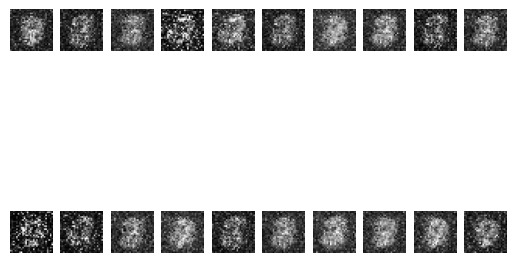

8/8 [==============================] - 0s 3ms/step
300 loss_D 0.661215752363205 loss_G 0.6839949488639832


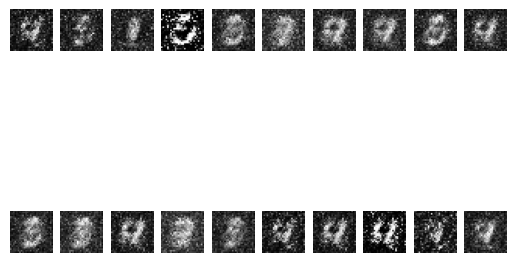

8/8 [==============================] - 0s 2ms/step
400 loss_D 0.6133939921855927 loss_G 0.7476468682289124


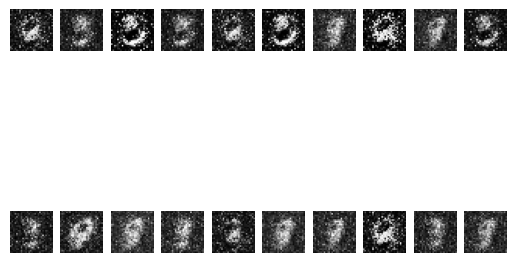

8/8 [==============================] - 0s 2ms/step
500 loss_D 0.6272309422492981 loss_G 0.7873664498329163


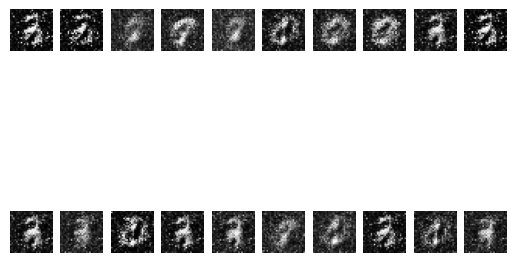

8/8 [==============================] - 0s 3ms/step
600 loss_D 0.6021502017974854 loss_G 0.8136404752731323


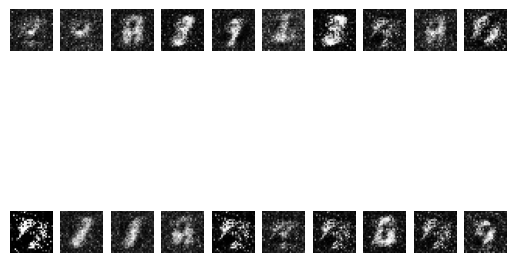

8/8 [==============================] - 0s 3ms/step
700 loss_D 0.6094240248203278 loss_G 0.8528833389282227


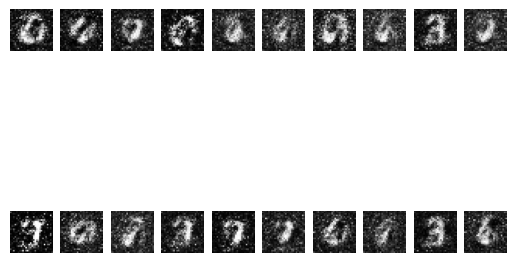

8/8 [==============================] - 0s 2ms/step
800 loss_D 0.5729591697454453 loss_G 0.9174551367759705


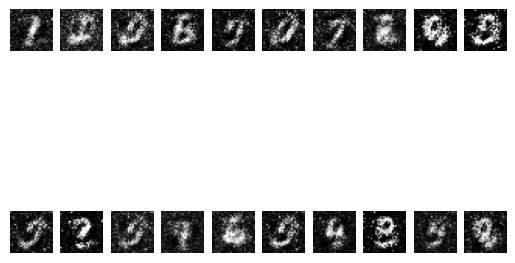

8/8 [==============================] - 0s 3ms/step
900 loss_D 0.570551335811615 loss_G 0.9891281723976135


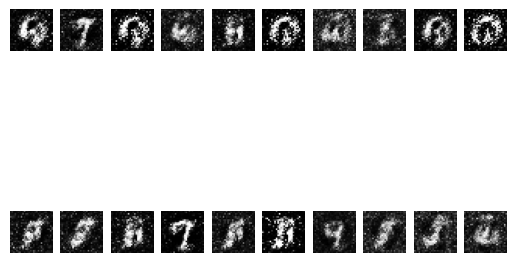

8/8 [==============================] - 0s 3ms/step
1000 loss_D 0.56145279109478 loss_G 1.0299071073532104


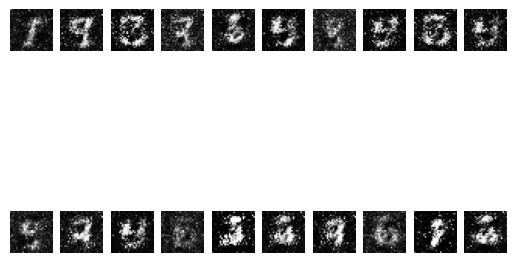

8/8 [==============================] - 0s 4ms/step
1100 loss_D 0.5838117897510529 loss_G 0.9965097904205322


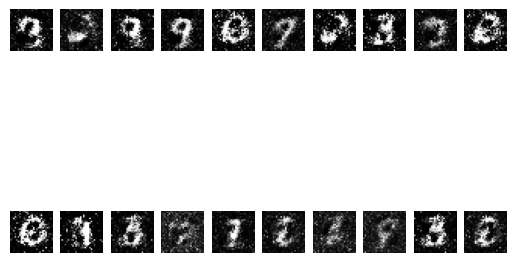

8/8 [==============================] - 0s 3ms/step
1200 loss_D 0.6086382269859314 loss_G 1.0350275039672852


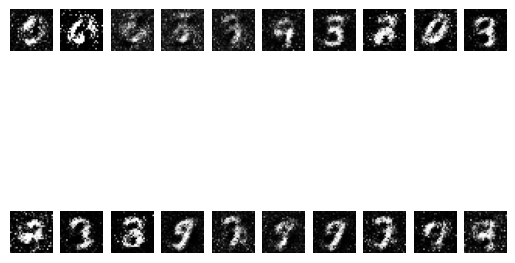

8/8 [==============================] - 0s 2ms/step
1300 loss_D 0.5480083227157593 loss_G 1.0890898704528809


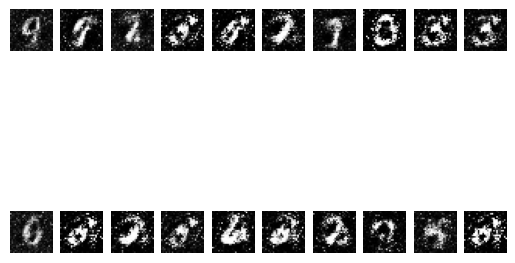

8/8 [==============================] - 0s 3ms/step
1400 loss_D 0.5525250732898712 loss_G 1.0772954225540161


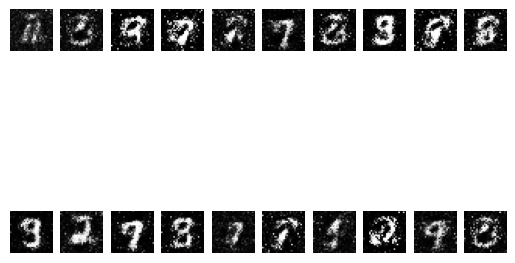

8/8 [==============================] - 0s 3ms/step
1500 loss_D 0.5737008452415466 loss_G 1.0270206928253174


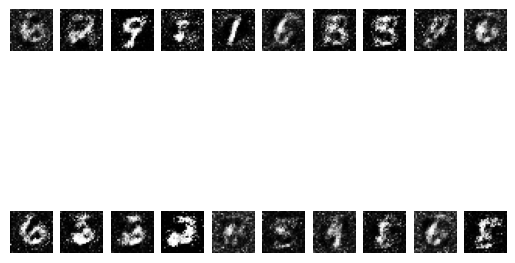

8/8 [==============================] - 0s 4ms/step
1600 loss_D 0.6048881709575653 loss_G 0.9635955095291138


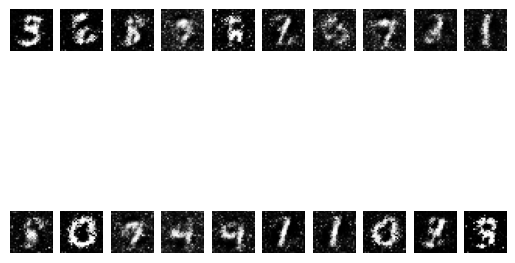

8/8 [==============================] - 0s 3ms/step
1700 loss_D 0.5721071064472198 loss_G 1.0179109573364258


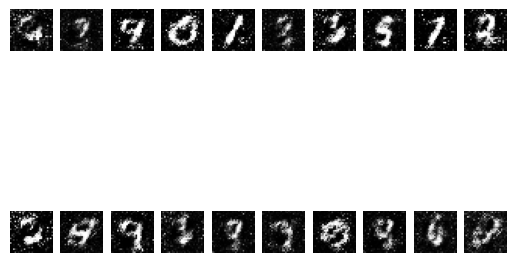

8/8 [==============================] - 0s 3ms/step
1800 loss_D 0.5899358689785004 loss_G 0.9719681739807129


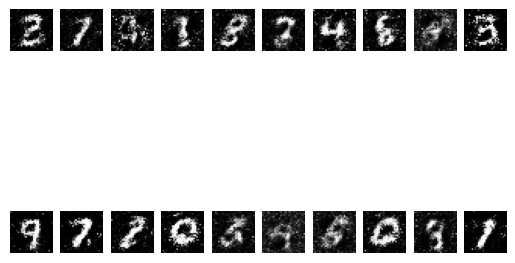

8/8 [==============================] - 0s 4ms/step
1900 loss_D 0.5888144075870514 loss_G 0.9397963285446167


<ipython-input-16-17cbab5cbae4>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(r, c)


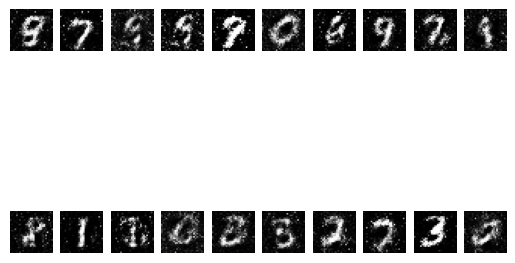

8/8 [==============================] - 0s 3ms/step
2000 loss_D 0.6089351773262024 loss_G 0.9736025333404541


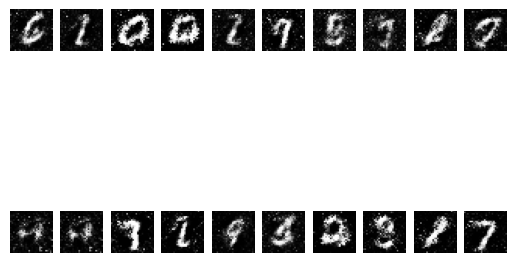

8/8 [==============================] - 0s 4ms/step
2100 loss_D 0.584835946559906 loss_G 0.9639080762863159


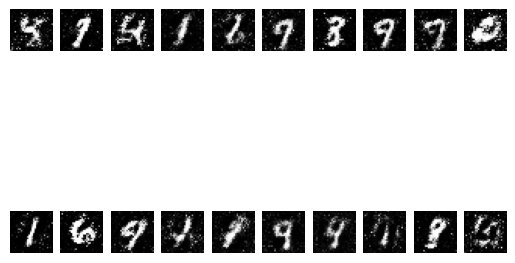

8/8 [==============================] - 0s 3ms/step
2200 loss_D 0.6045423150062561 loss_G 0.951033353805542


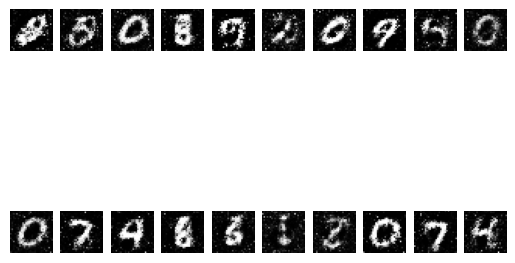

8/8 [==============================] - 0s 4ms/step
2300 loss_D 0.61428502202034 loss_G 0.9309136867523193


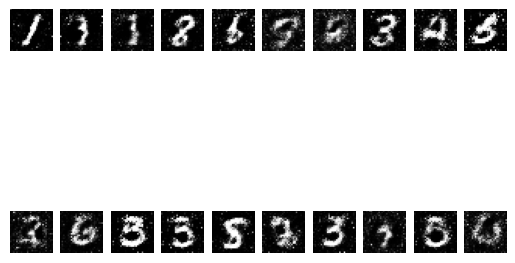

8/8 [==============================] - 0s 2ms/step
2400 loss_D 0.6228592395782471 loss_G 0.9099187850952148


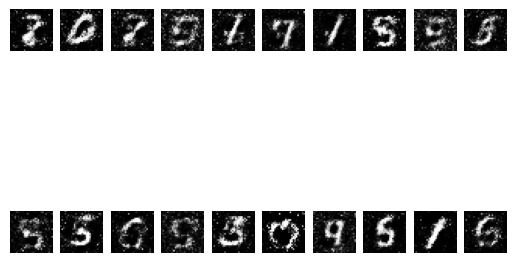

8/8 [==============================] - 0s 3ms/step
2500 loss_D 0.6123012602329254 loss_G 0.8915629982948303


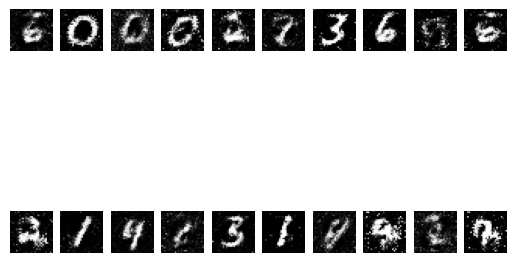

8/8 [==============================] - 0s 3ms/step
2600 loss_D 0.637908399105072 loss_G 0.8909534215927124


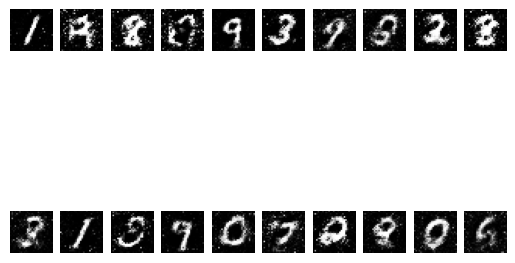

8/8 [==============================] - 0s 3ms/step
2700 loss_D 0.6216093003749847 loss_G 0.9209145307540894


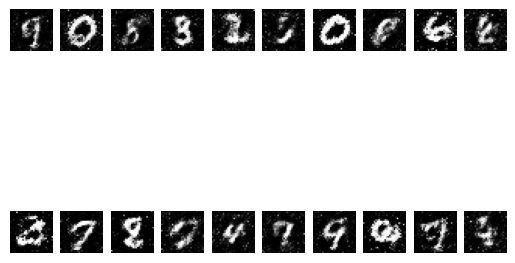

8/8 [==============================] - 0s 3ms/step
2800 loss_D 0.6244899034500122 loss_G 0.9014543890953064


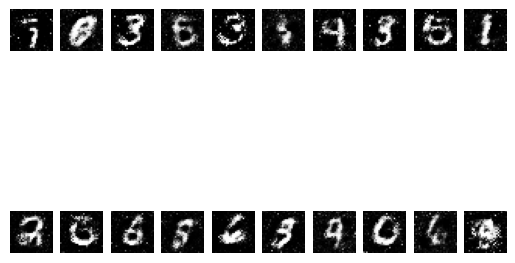

8/8 [==============================] - 0s 4ms/step
2900 loss_D 0.6170986592769623 loss_G 0.9027507305145264


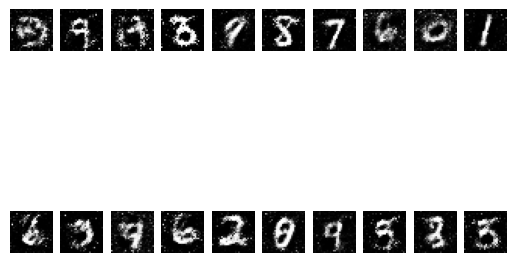

8/8 [==============================] - 0s 3ms/step
3000 loss_D 0.6446297466754913 loss_G 0.8746134042739868


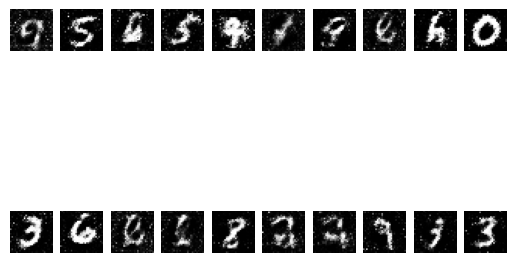

8/8 [==============================] - 0s 4ms/step
3100 loss_D 0.6494782865047455 loss_G 0.8718661069869995


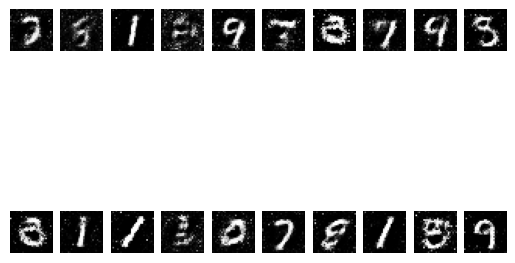

8/8 [==============================] - 0s 3ms/step
3200 loss_D 0.648607611656189 loss_G 0.877151608467102


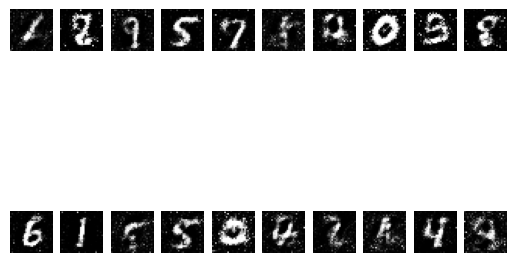

8/8 [==============================] - 0s 3ms/step
3300 loss_D 0.6615334451198578 loss_G 0.8852057456970215


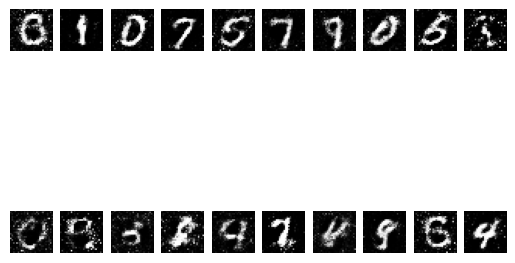

8/8 [==============================] - 0s 4ms/step
3400 loss_D 0.6426410675048828 loss_G 0.8713507652282715


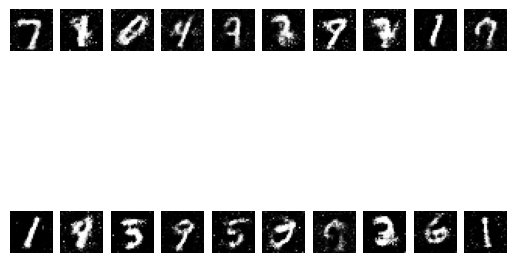

8/8 [==============================] - 0s 3ms/step
3500 loss_D 0.6407783031463623 loss_G 0.874131977558136


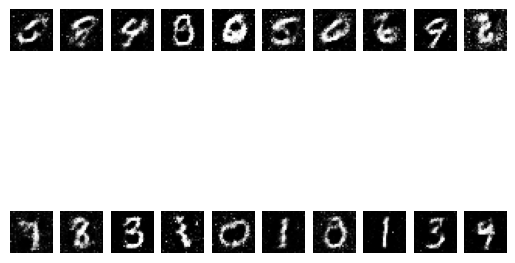

8/8 [==============================] - 0s 3ms/step
3600 loss_D 0.6526477634906769 loss_G 0.8814976811408997


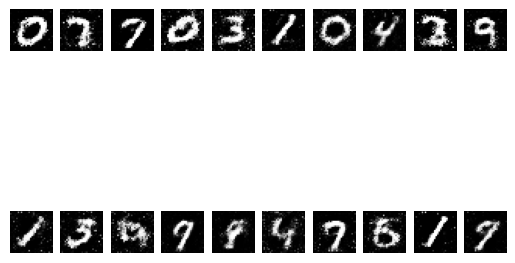

8/8 [==============================] - 0s 4ms/step
3700 loss_D 0.6395385563373566 loss_G 0.8838200569152832


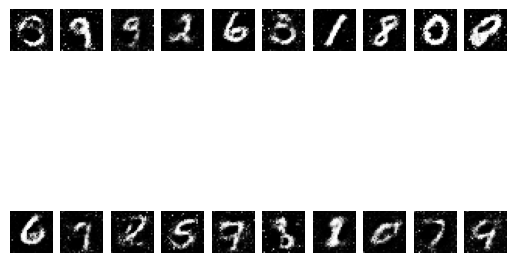

8/8 [==============================] - 0s 4ms/step
3800 loss_D 0.6511951684951782 loss_G 0.8741709589958191


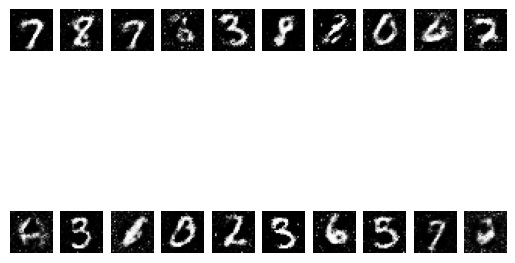

8/8 [==============================] - 0s 4ms/step
3900 loss_D 0.6410415470600128 loss_G 0.8851126432418823


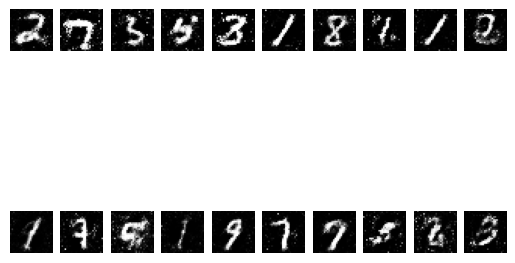

8/8 [==============================] - 0s 3ms/step
4000 loss_D 0.6586346328258514 loss_G 0.8497947454452515


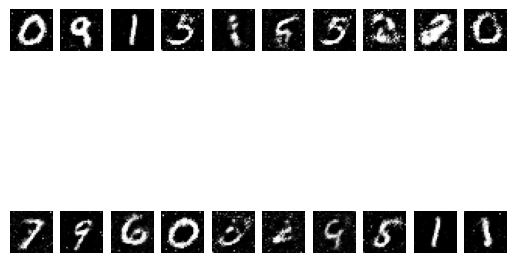

8/8 [==============================] - 0s 4ms/step
4100 loss_D 0.6487166285514832 loss_G 0.8871654272079468


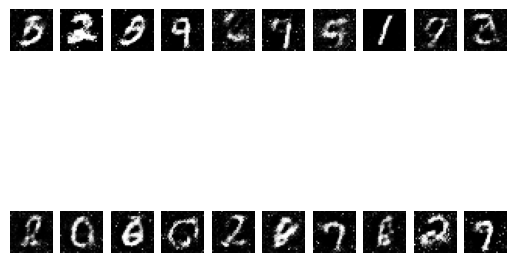

8/8 [==============================] - 0s 2ms/step
4200 loss_D 0.6425420343875885 loss_G 0.8773909211158752


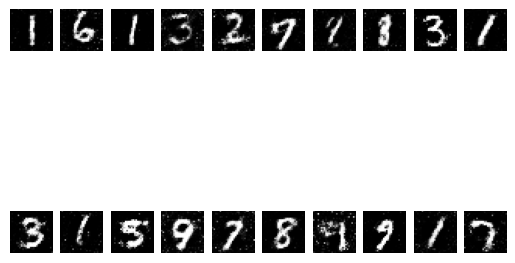

8/8 [==============================] - 0s 4ms/step
4300 loss_D 0.6770502626895905 loss_G 0.854896068572998


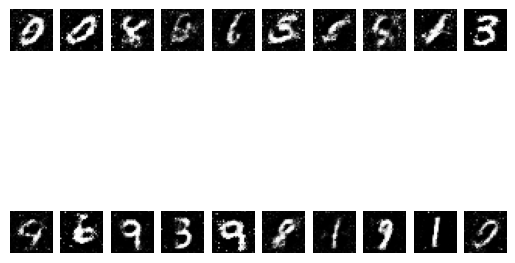

8/8 [==============================] - 0s 3ms/step
4400 loss_D 0.6516641080379486 loss_G 0.863089919090271


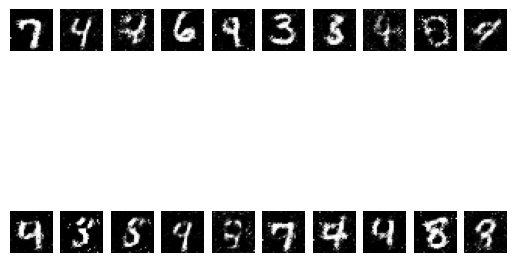

8/8 [==============================] - 0s 5ms/step
4500 loss_D 0.668391615152359 loss_G 0.8448787927627563


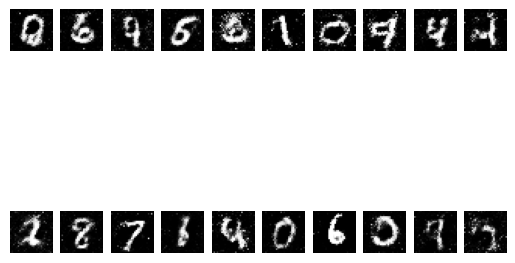

8/8 [==============================] - 0s 3ms/step
4600 loss_D 0.674590677022934 loss_G 0.8720394968986511


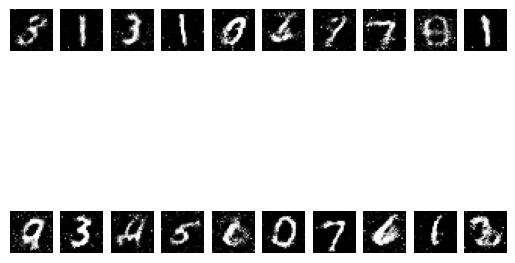

8/8 [==============================] - 0s 2ms/step
4700 loss_D 0.660466730594635 loss_G 0.8677294254302979


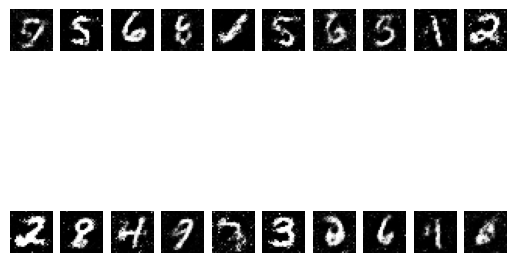

8/8 [==============================] - 0s 4ms/step
4800 loss_D 0.6591604948043823 loss_G 0.8459129333496094


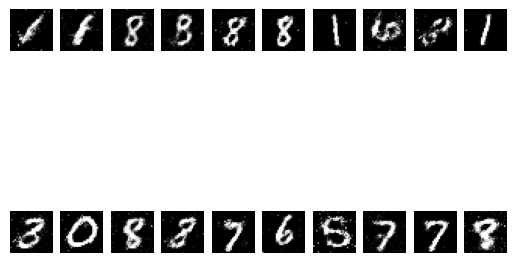

8/8 [==============================] - 0s 3ms/step
4900 loss_D 0.6511126458644867 loss_G 0.8434919118881226


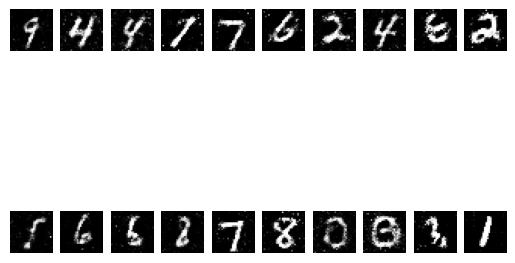

8/8 [==============================] - 0s 3ms/step


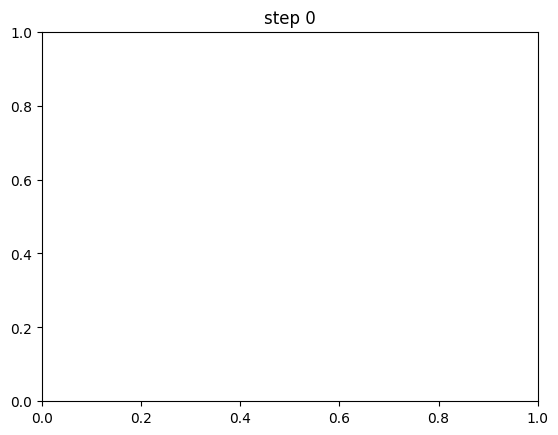

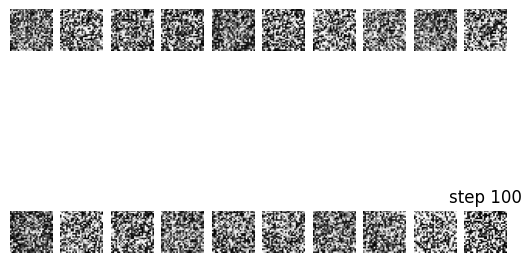

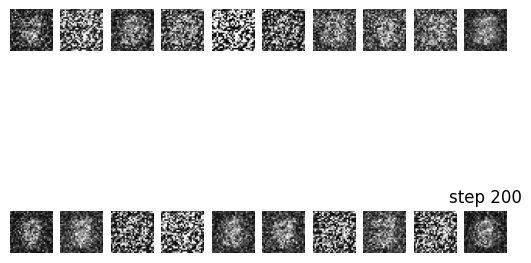

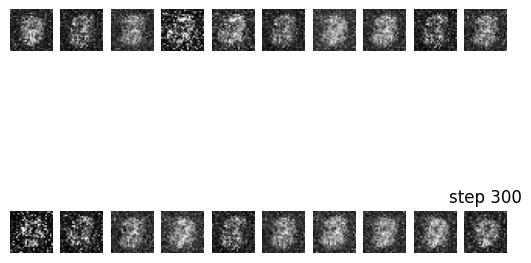

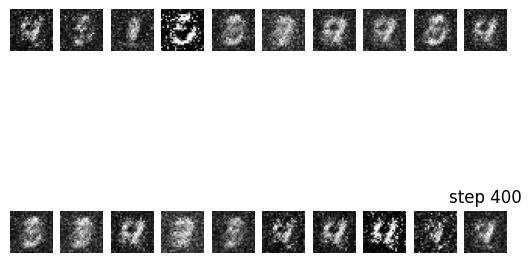

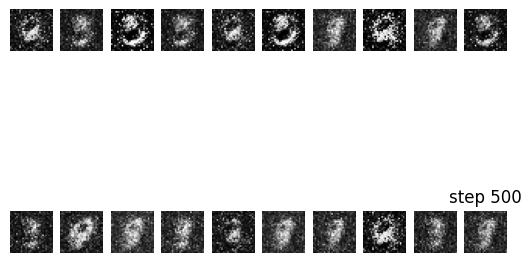

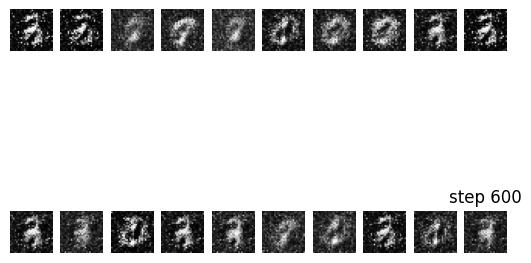

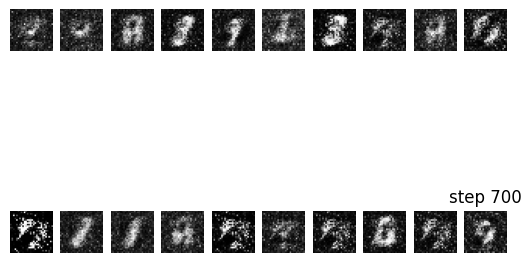

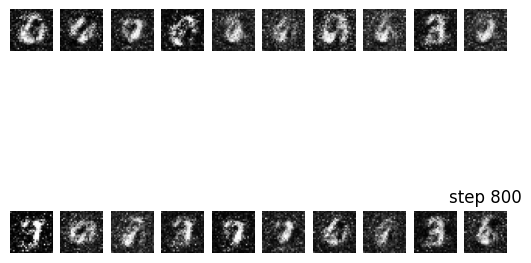

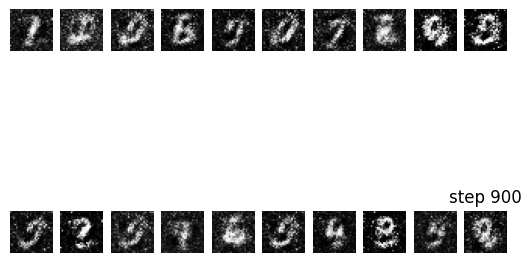

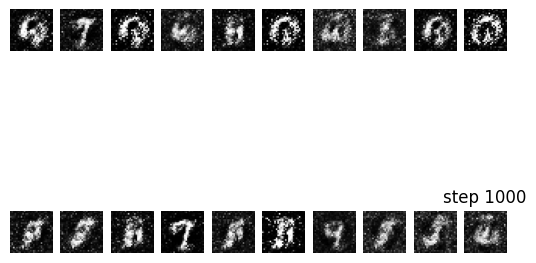

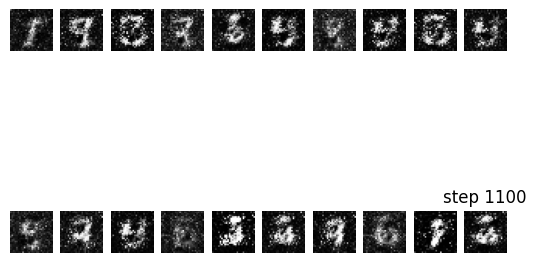

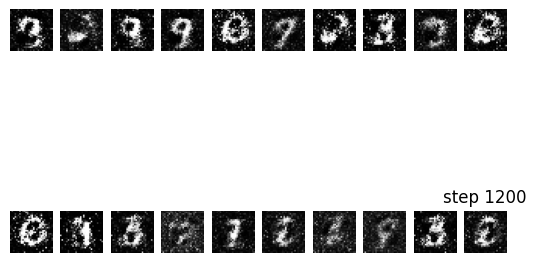

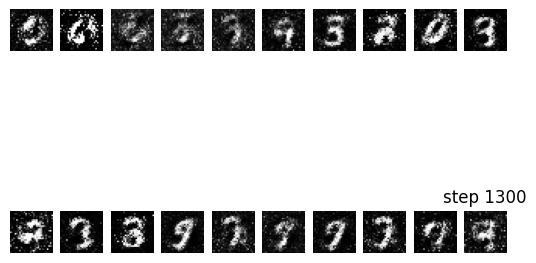

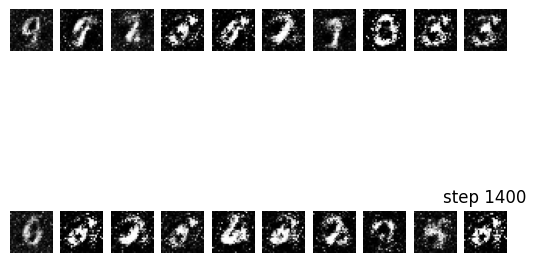

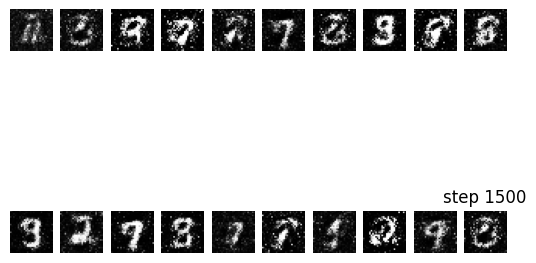

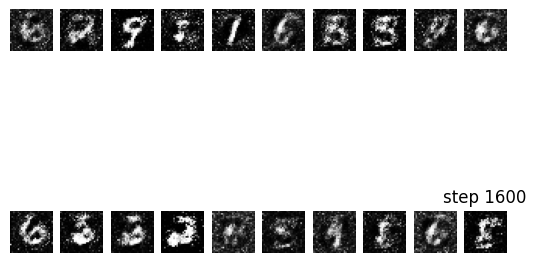

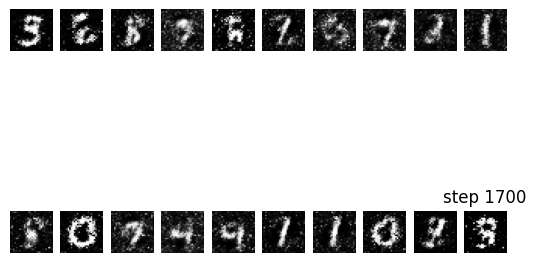

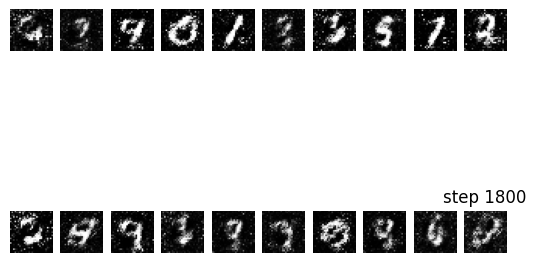

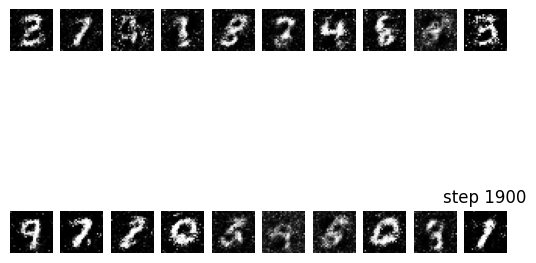

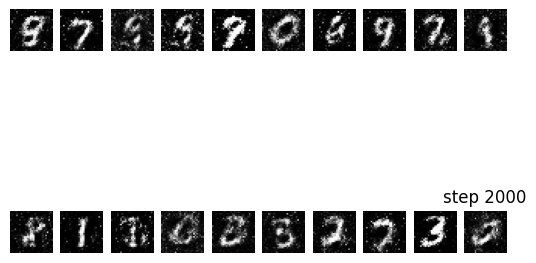

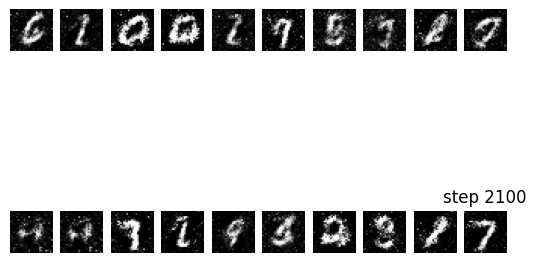

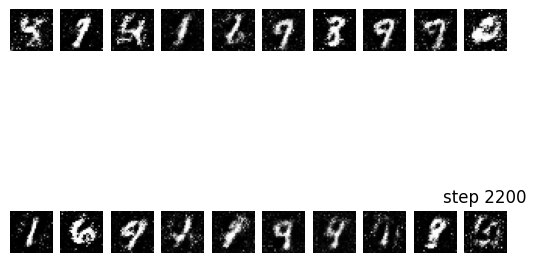

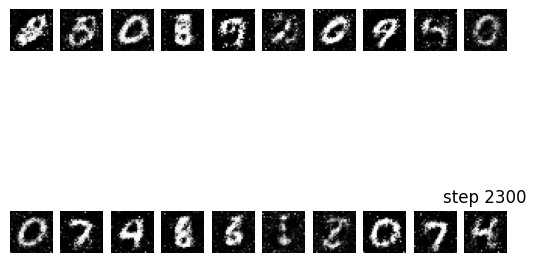

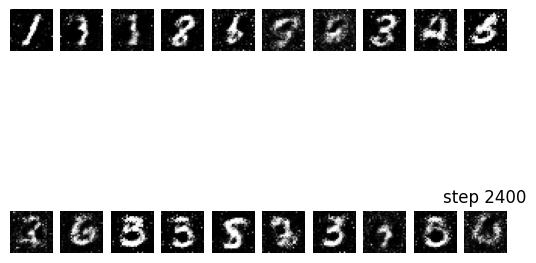

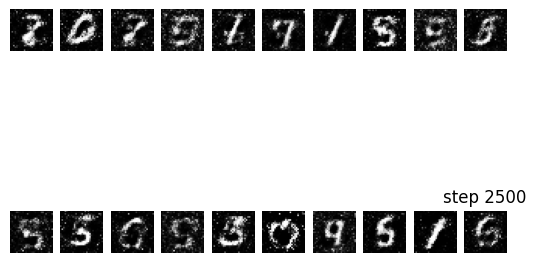

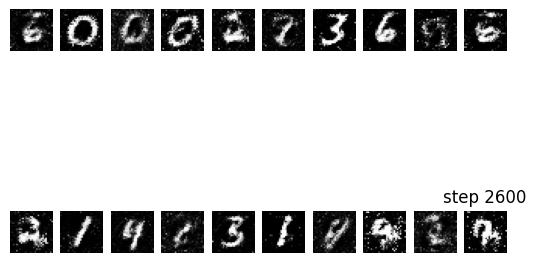

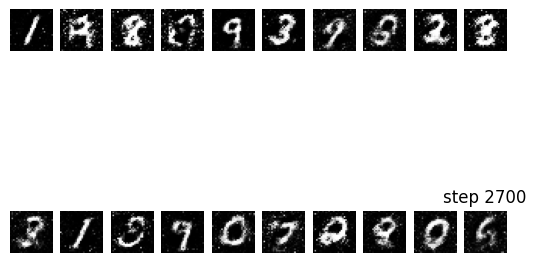

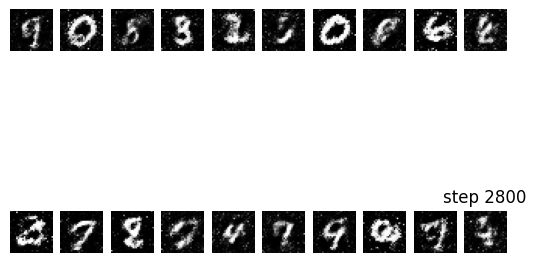

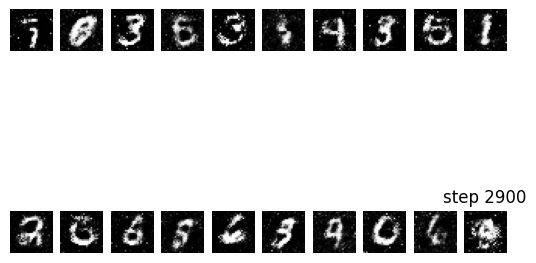

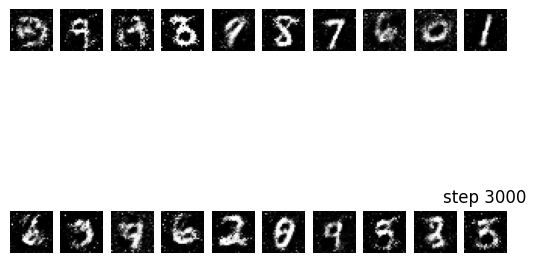

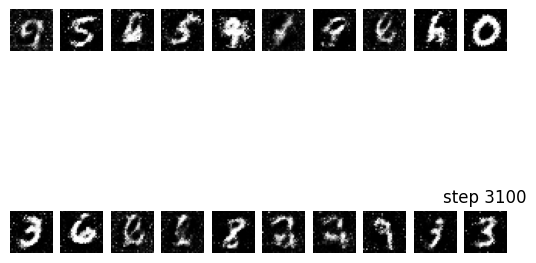

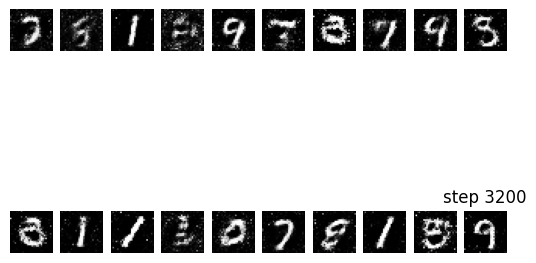

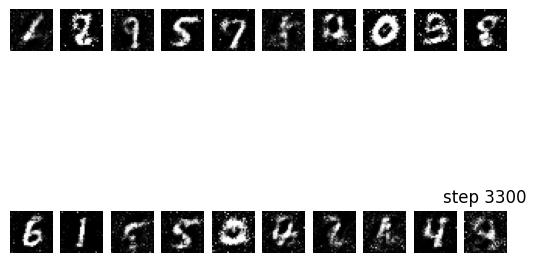

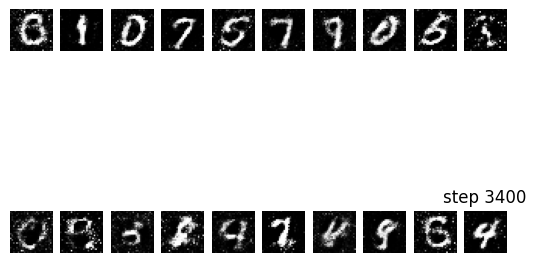

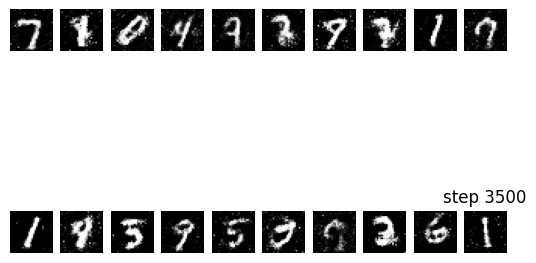

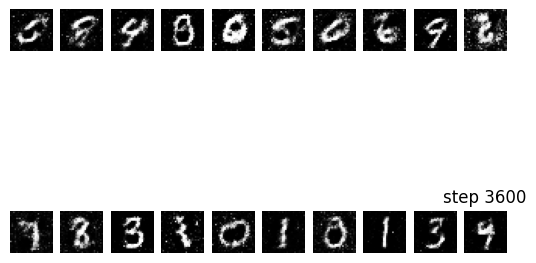

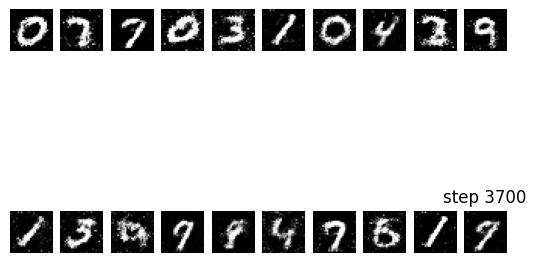

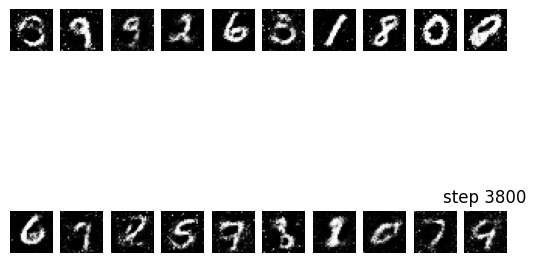

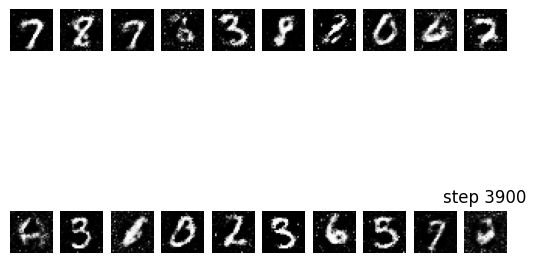

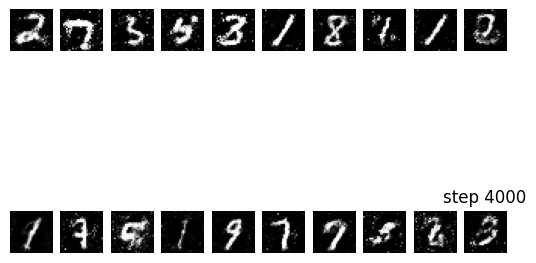

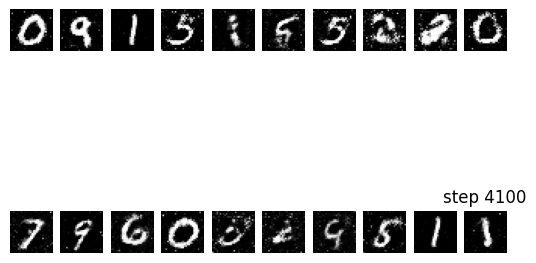

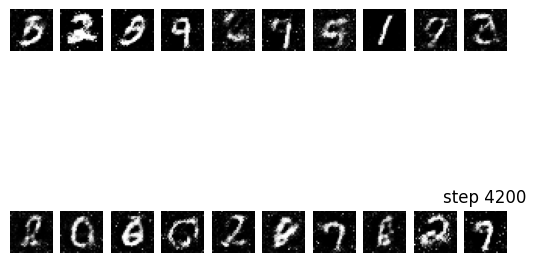

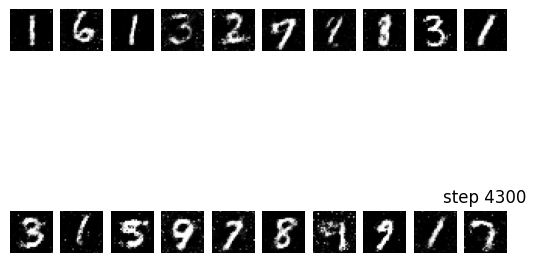

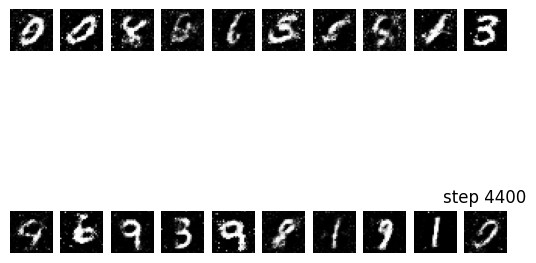

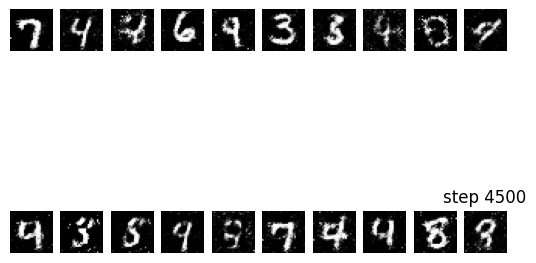

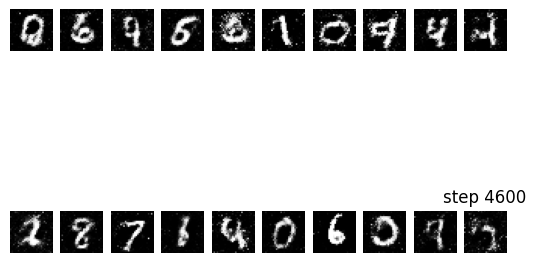

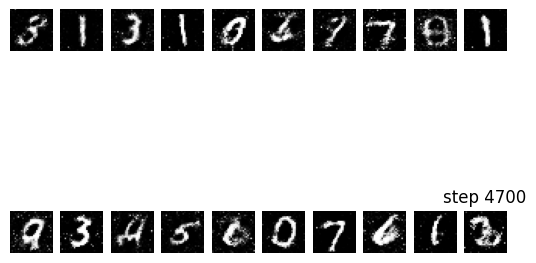

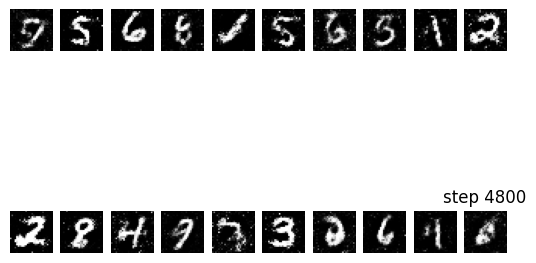

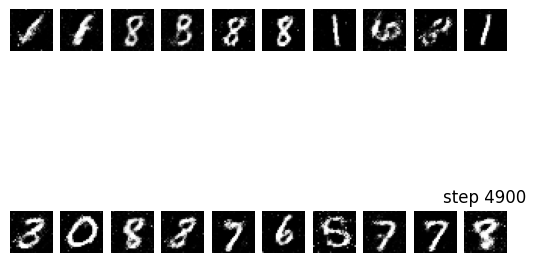

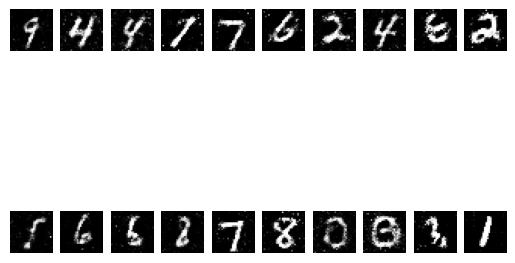

In [18]:
# training generator and discriminator
for step in range(5000):
  # select a random batch of images
  idx = np.random.randint(0, x_train.shape[0], batch_size)  # define batch_size number of random indexes
  imgs = x_train[idx]  # select these random indexes from x_train
  
  # generating a batch of fake images
  noise = np.random.normal(0, 1, (batch_size, gan.latent_dim))  # create batch_size number of gan.latent_dim dimensional np.random.normal noise samples with 0 mean and 1 variance
  gen_imgs = gan.generator.predict(noise)


  # training the discriminator
  d_loss_real = gan.discriminator.train_on_batch(imgs, np.ones((batch_size, 1)))  # train on real images with "valid" labels (1)
  d_loss_fake = gan.discriminator.train_on_batch(gen_imgs, np.zeros((batch_size, 1)))  # train on fake images with "fake" labels (0)
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

  # training the generator
  g_loss = gan.combined.train_on_batch(noise, np.ones((batch_size, 1)))  # train on fake images with "valid" labels (1)

  # printing out the log and plotting the generated images
  if step % 100 == 0:
      print(step, 'loss_D', d_loss[0], 'loss_G', g_loss)
      plot_images(gan, step)
    

## Inference
Generating a single image can be easily performed.

1/1 [==============================] - 0s 149ms/step


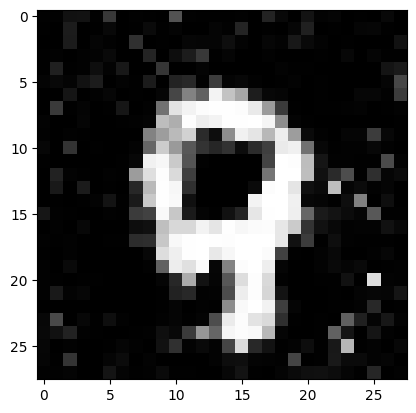

In [19]:
noise = np.random.normal(0, 1, (1, gan.latent_dim)) # defining noise for the generator for 1 image
gen_img = gan.generator.predict(noise) # generating image from noise
plt.imshow(gen_img.squeeze(), cmap='gray') # displaying the generated image